In [ ]:
pip install opencv-python numpy

In [ ]:
#importing the required libraries
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
#importing the image of eye and reading it
image_path = '/content/drive/MyDrive/IrisDetection&Recognition/eye2.jpg'
image = cv2.imread(image_path)

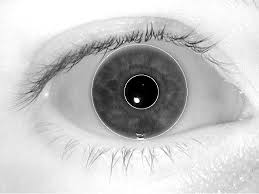

In [ ]:
#displaying the imported image
cv2_imshow(image)

In [ ]:
#resizing the image for further process
new_width = 260
new_height = 200
resized_image = cv2.resize(image, (new_width, new_height))

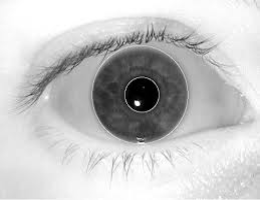

In [ ]:
#displaying the resized image
cv2_imshow(resized_image)

In [ ]:
#converting the image into gray-scale
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

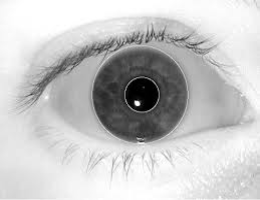

In [ ]:
#displaying the grayscaled image
cv2_imshow(gray_image)

In [ ]:
#enhancing the grayscaled image
equalized_gray = cv2.equalizeHist(gray_image)

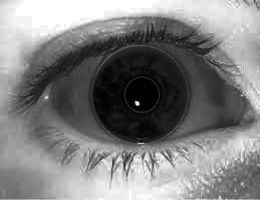

In [ ]:
#displaying the enhanced grayscale image
cv2_imshow(equalized_gray)

In [ ]:
#performing edge detection (segmentation on the enhanced image)
edges = cv2.Canny(equalized_gray, threshold1=70, threshold2=120)

In [ ]:
#finding the circles (iris) in the image using Hough circles
circles = cv2.HoughCircles(
    edges,
    cv2.HOUGH_GRADIENT,
    dp=1, minDist=20,
    param1=50, param2=30, minRadius=25, maxRadius=50
)

In [ ]:
#creating a green circle (pinpointing) over the areas detected as iris
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        x, y, r = circle
        iris_region = resized_image[y - r:y + r, x - r:x + r]
        cv2.circle(resized_image, (x, y), r, (0, 255, 0), 2)

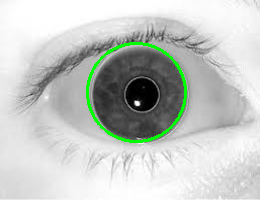

In [ ]:
#displaying the iris region in the resized image
cv2_imshow(resized_image)

In [ ]:
#creating a canvas for representation of dimensionally consistent iris (normalization)
canvas_width = 6*r
canvas_height = r
normalized_iris = np.zeros((canvas_height, canvas_width), dtype=np.uint8)

In [ ]:
#mapping the circular iris region to the square canvas using polar-to-Cartesian coordinates
for x_prime in range(canvas_width):
    for y_prime in range(canvas_height):
        theta = 2 * np.pi * (x_prime / canvas_width)  # Convert x' to angle
        radius = r * (y_prime / canvas_height)  # Convert y' to radius
        x_iris = int(x + radius * np.cos(theta))
        y_iris = int(y + radius * np.sin(theta))

        if 0 <= x_iris < equalized_gray.shape[1] and 0 <= y_iris < equalized_gray.shape[0]:
            normalized_iris[y_prime, x_prime] = equalized_gray[y_iris, x_iris]

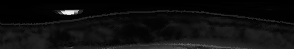

In [ ]:
#displaying the normalized iris
cv2_imshow(normalized_iris)

In [ ]:
#defining LBP parameter and applying LBP for feature extraction (feature encoding)
n_points = 8 * r
lbp_image = np.zeros_like(normalized_iris)
lbp_image = cv2.copyMakeBorder(lbp_image, 1, 1, 1, 1, cv2.BORDER_CONSTANT)  # Padding for edge pixels
for i in range(1, normalized_iris.shape[0] - 1):
    for j in range(1, normalized_iris.shape[1] - 1):
        center = normalized_iris[i, j]
        binary_code = 0
        for n in range(n_points):
            x = j + int(radius * np.cos(2 * np.pi * n / n_points))
            y = i - int(radius * np.sin(2 * np.pi * n / n_points))

            if 0 <= x < normalized_iris.shape[1] and 0 <= y < normalized_iris.shape[0]:
                binary_code |= (normalized_iris[y, x] > center) << n
        lbp_image[i, j] = binary_code

In [ ]:
#calculating the LBP histogram to represent the iris
histogram = cv2.calcHist([lbp_image], [0], None, [256], [0, 256])

In [ ]:
#normalizing histogram
normalized_histogram = histogram / histogram.sum()

In [ ]:
#printing the normalized histogram
print (normalized_histogram)

[[5.5438524e-01]
 [4.5045046e-03]
 [6.2268148e-03]
 [3.5307366e-02]
 [6.8229996e-03]
 [1.7223106e-03]
 [1.9872815e-03]
 [3.7029676e-02]
 [7.7503975e-03]
 [1.9872814e-04]
 [6.6242712e-05]
 [1.2586116e-03]
 [1.0135135e-02]
 [1.4573397e-03]
 [2.1197668e-03]
 [2.5437202e-02]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [0.0000000e+00]
 [3.3783785e-03]
 [1.9872814e-04]
 [1.3248542e-04]
 [6.6242710e-04]
 [6.6242712e-05]
 [0.0000000e+00]
 [0.0000000e+00]
 [1.3248542e-03]
 [8.0816112e-03]
 [3.9745629e-04]
 [3.9745629e-0

In [ ]:
#creating a 2D histogram image for better visualization
hist_image = np.zeros((r, r*6), dtype=np.uint8)

In [ ]:
#maping the normalized histogram values to the 2D histogram image
for pattern, count in enumerate(normalized_histogram):
    hist_image[:, pattern] = int(255 * count)  # Scale for visualization

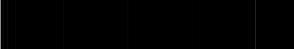

In [ ]:
#displaying the histogram image
cv2_imshow(hist_image)

In [ ]:
#saving the histogram
histogram_file = 'normalized_histogram_eye2.pkl'

with open(histogram_file, 'wb') as file:
    pickle.dump(normalized_histogram, file)

print(f'LBP histogram saved to {histogram_file}')

LBP histogram saved to normalized_histogram_eye2.pkl
